In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

In [2]:
FIRST_CONDITION = 500
SECOND_CONDITION = 400
THIRD_CONDITION =  300
FOURTH_CONDITION = 200
FIFTH_CONDITION = 100

## helper function to load and parse annotations

In [3]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [4]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [5]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

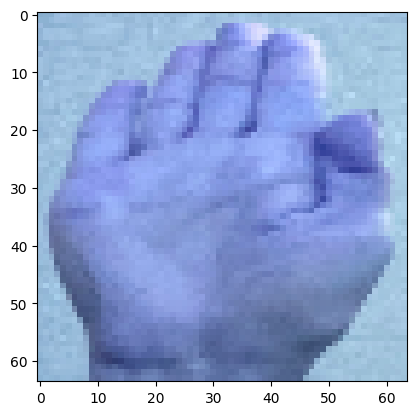

In [6]:
plt.imshow(random.sample(images, 1)[0])

In [6]:
def train_model(dataset_size):

    # https://stackoverflow.com/questions/61550026/valueerror-shapes-none-1-and-none-3-are-incompatible

    X_train, X_test, y_train, y_test = train_test_split(images[:dataset_size], labels[:dataset_size], test_size=0.2, random_state=42)

    # training and test data
    print(len(X_train))
    print(len(X_test))
    print(len(y_train))
    print(len(y_test))

    X_train = np.array(X_train).astype('float32')
    X_train = X_train / 255.

    X_test = np.array(X_test).astype('float32')
    X_test = X_test / 255.

    y_train_one_hot = to_categorical(y_train, 3)
    y_test_one_hot = to_categorical(y_test, 3)

    train_label = y_train_one_hot
    test_label = y_test_one_hot

    X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
    X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

    # transformed data
    print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

    # variables for hyperparameters
    batch_size = 8
    epochs = 50
    num_classes = len(label_names)
    activation = 'relu'
    activation_conv = 'LeakyReLU'  # LeakyReLU
    layer_count = 2
    num_neurons = 64

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    model.add(RandomFlip('horizontal'))
    model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    # define callback functions that react to the model's behavior during training
    # in this example, we reduce the learning rate once we get stuck and early stopping
    # to cancel the training if there are no improvements for a certain amount of epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(
        X_train,
        train_label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, test_label),
        callbacks=[reduce_lr, stop_early]
    )

    return history, model, X_test, y_test



## Plot accuracy and loss of the training process

In [12]:
def show_training_results(history, model):

    model.summary()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

# FIRST CONDITION 250

In [7]:
history, model, X_test, y_test = train_model(FIRST_CONDITION)

dies:640
640
500
500
512
128
512
128
(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)
Epoch 1/50
64/64 [==============================] - 4s 39ms/step - loss: 1.0778 - accuracy: 0.3965 - val_loss: 1.0371 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 2s 37ms/step - loss: 1.0278 - accuracy: 0.4258 - val_loss: 1.0374 - val_accuracy: 0.3906 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 2s 37ms/step - loss: 0.9841 - accuracy: 0.4902 - val_loss: 0.8939 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 2s 37ms/step - loss: 0.7491 - accuracy: 0.6855 - val_loss: 1.0076 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 2s 37ms/step - loss: 0.5926 - accuracy: 0.7793 - val_loss: 0.3431 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 2s 37ms/step - loss: 0.3538 - accuracy: 0.8711 - val_loss: 0.3116 - val_accuracy: 0.9297 

In [8]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

4/4 [==============================] - 0s 17ms/step


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_13 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_13 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 6, 32)       

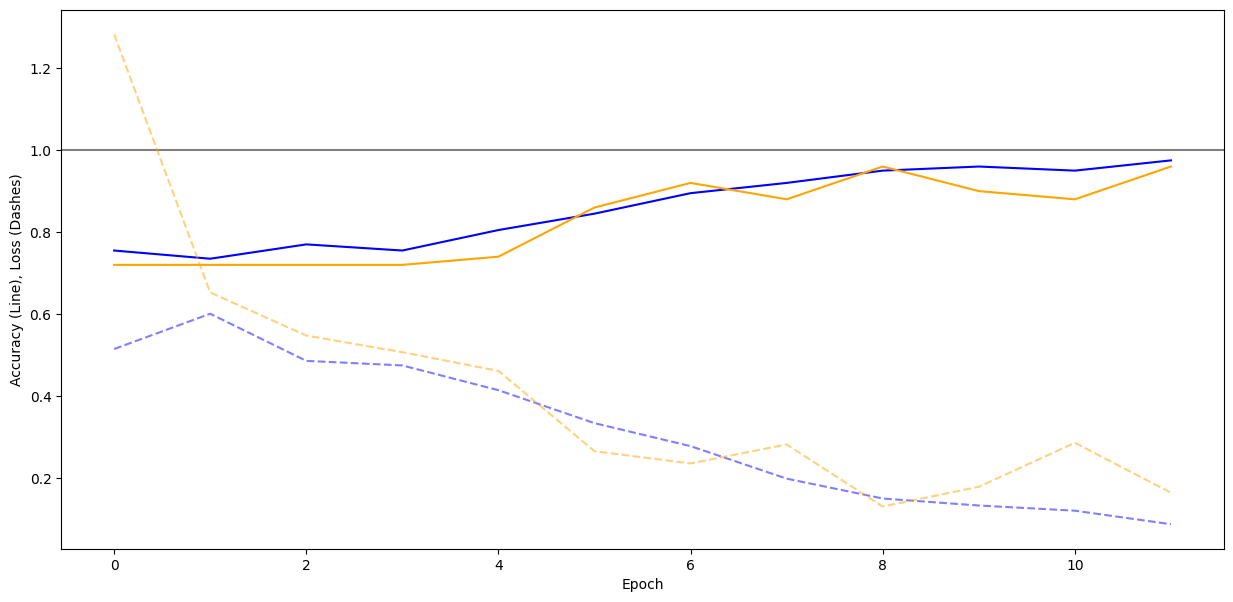

In [31]:
show_training_results(history, model)

# SECOND CONDITION 200

In [13]:
history, model, X_test, y_test  = train_model(SECOND_CONDITION)

160
40
160
40
(160, 64, 64, 3) (40, 64, 64, 3) (160, 3) (40, 3)
Epoch 1/50
20/20 [==============================] - 2s 42ms/step - loss: 0.6801 - accuracy: 0.7375 - val_loss: 0.5444 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 1s 37ms/step - loss: 0.5469 - accuracy: 0.7812 - val_loss: 0.4328 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 1s 37ms/step - loss: 0.5007 - accuracy: 0.7688 - val_loss: 0.5357 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 1s 37ms/step - loss: 0.4661 - accuracy: 0.7750 - val_loss: 0.4134 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 1s 37ms/step - loss: 0.4718 - accuracy: 0.7688 - val_loss: 0.3914 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 1s 36ms/step - loss: 0.4617 - accuracy: 0.7688 - val_loss: 0.3350 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 7/50
2

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_12 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_12 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 6, 6, 32)       

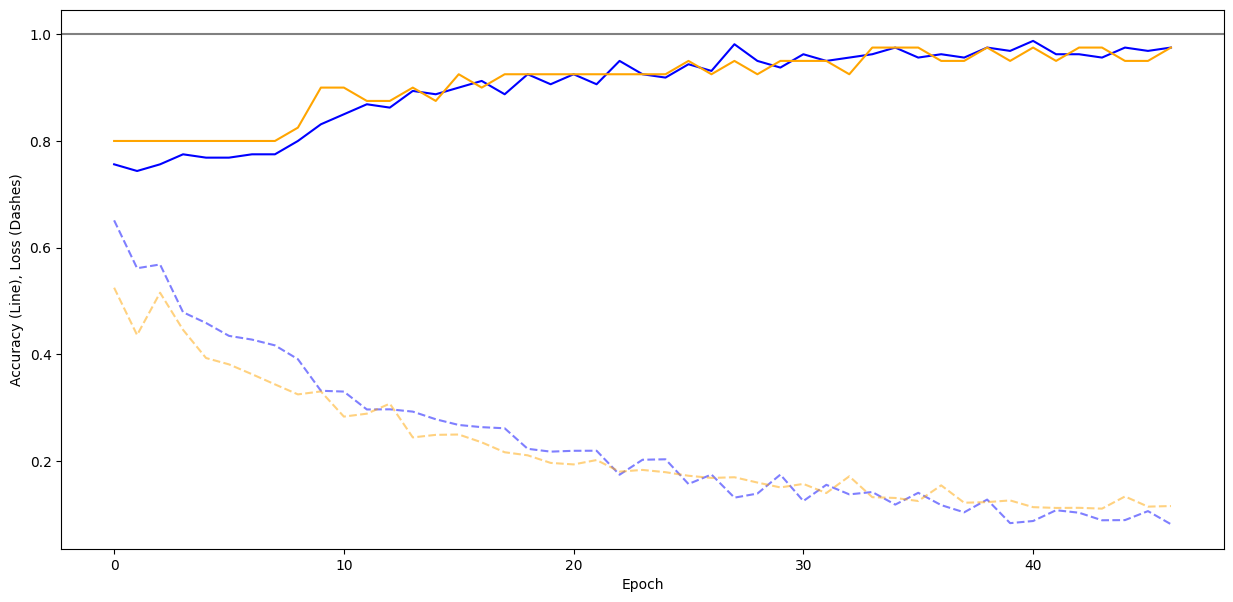

In [40]:
show_training_results(history, model)

In [ ]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# THIRD CONDITION 150

In [12]:
history, model, X_test, y_test  = train_model(THIRD_CONDITION)

120
30
120
30
(120, 64, 64, 3) (30, 64, 64, 3) (120, 3) (30, 3)
Epoch 1/50
15/15 [==============================] - 2s 47ms/step - loss: 0.6970 - accuracy: 0.6917 - val_loss: 0.4393 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 1s 39ms/step - loss: 0.5648 - accuracy: 0.7250 - val_loss: 0.4303 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 1s 39ms/step - loss: 0.5417 - accuracy: 0.7667 - val_loss: 0.4141 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 1s 39ms/step - loss: 0.4952 - accuracy: 0.7583 - val_loss: 0.3942 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 1s 39ms/step - loss: 0.4450 - accuracy: 0.7583 - val_loss: 0.4639 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 1s 39ms/step - loss: 0.4928 - accuracy: 0.7500 - val_loss: 0.3447 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 7/50
1

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_13 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_13 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 6, 32)       

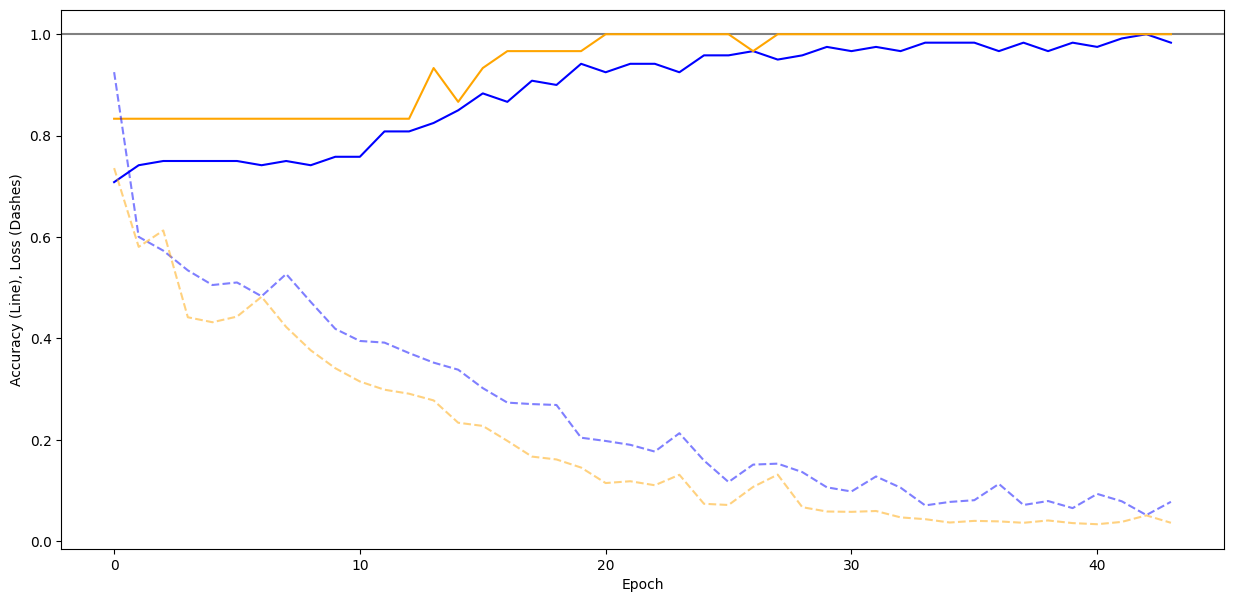

In [42]:
show_training_results(history, model)

In [ ]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# FOURTH CONDITION 100

In [10]:
history, model, X_test, y_test  = train_model(FOURTH_CONDITION)

80
20
80
20
(80, 64, 64, 3) (20, 64, 64, 3) (80, 3) (20, 3)
Epoch 1/50
10/10 [==============================] - 2s 51ms/step - loss: 0.7260 - accuracy: 0.7250 - val_loss: 0.4960 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 0s 40ms/step - loss: 0.5821 - accuracy: 0.7125 - val_loss: 0.4022 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 0s 40ms/step - loss: 0.5321 - accuracy: 0.7250 - val_loss: 0.2927 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 0s 40ms/step - loss: 0.4951 - accuracy: 0.7500 - val_loss: 0.5662 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 0s 39ms/step - loss: 0.5539 - accuracy: 0.7375 - val_loss: 0.4312 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 0s 39ms/step - loss: 0.5060 - accuracy: 0.7375 - val_loss: 0.2619 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 7/50
1

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_14 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_14 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 6, 6, 32)       

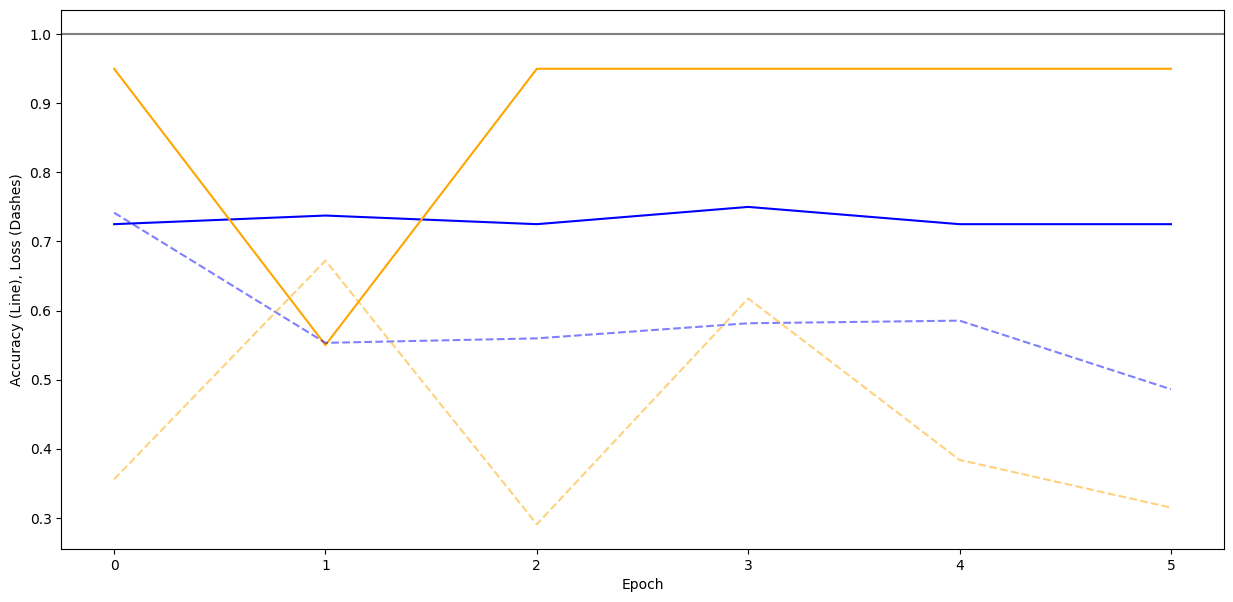

In [44]:
show_training_results(history, model)

In [ ]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# FIFTH CONDITION 50

In [15]:
history, model, X_test, y_test  = train_model(FIFTH_CONDITION)

40
10
40
10
(40, 64, 64, 3) (10, 64, 64, 3) (40, 3) (10, 3)
Epoch 1/50
5/5 [==============================] - 2s 69ms/step - loss: 0.9633 - accuracy: 0.7500 - val_loss: 0.8624 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 0s 41ms/step - loss: 0.9806 - accuracy: 0.7500 - val_loss: 0.6933 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 0s 42ms/step - loss: 0.6848 - accuracy: 0.7500 - val_loss: 0.4341 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 0s 41ms/step - loss: 0.7072 - accuracy: 0.7500 - val_loss: 0.4047 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 0s 41ms/step - loss: 0.6653 - accuracy: 0.7500 - val_loss: 0.5962 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - 0s 42ms/step - loss: 0.6009 - accuracy: 0.7500 - val_loss: 0.4320 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 7/50
5/5 [============

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_contrast_6 (RandomCo  (None, 64, 64, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 32)        

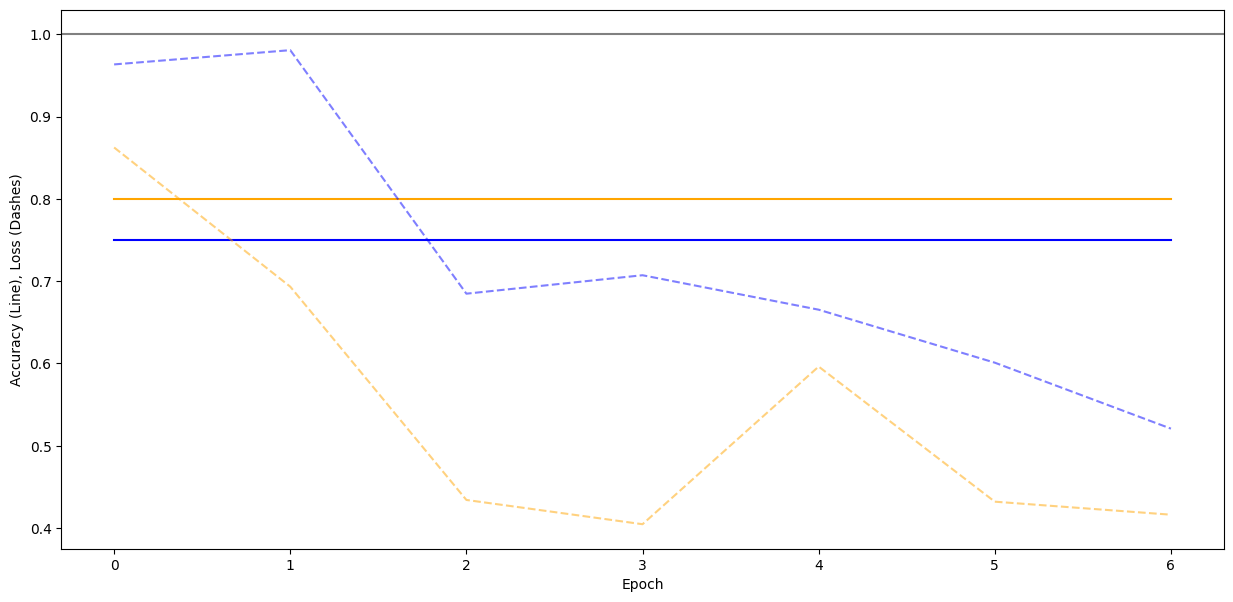

In [16]:
show_training_results(history, model)

In [ ]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# training and test data
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train, 3)
y_test_one_hot = to_categorical(y_test, 3)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

# transformed data
print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

512
128
512
128
(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)
Epoch 1/50
64/64 [==============================] - 4s 38ms/step - loss: 1.0680 - accuracy: 0.4102 - val_loss: 1.0703 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 2s 36ms/step - loss: 1.0196 - accuracy: 0.4434 - val_loss: 0.9162 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 2s 36ms/step - loss: 0.8861 - accuracy: 0.5898 - val_loss: 0.7114 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 2s 36ms/step - loss: 0.6642 - accuracy: 0.7227 - val_loss: 0.4670 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 2s 36ms/step - loss: 0.3950 - accuracy: 0.8672 - val_loss: 0.2969 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 2s 36ms/step - loss: 0.2941 - accuracy: 0.8906 - val_loss: 0.2522 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 7/

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_1 (RandomCo  (None, 64, 64, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 32)        

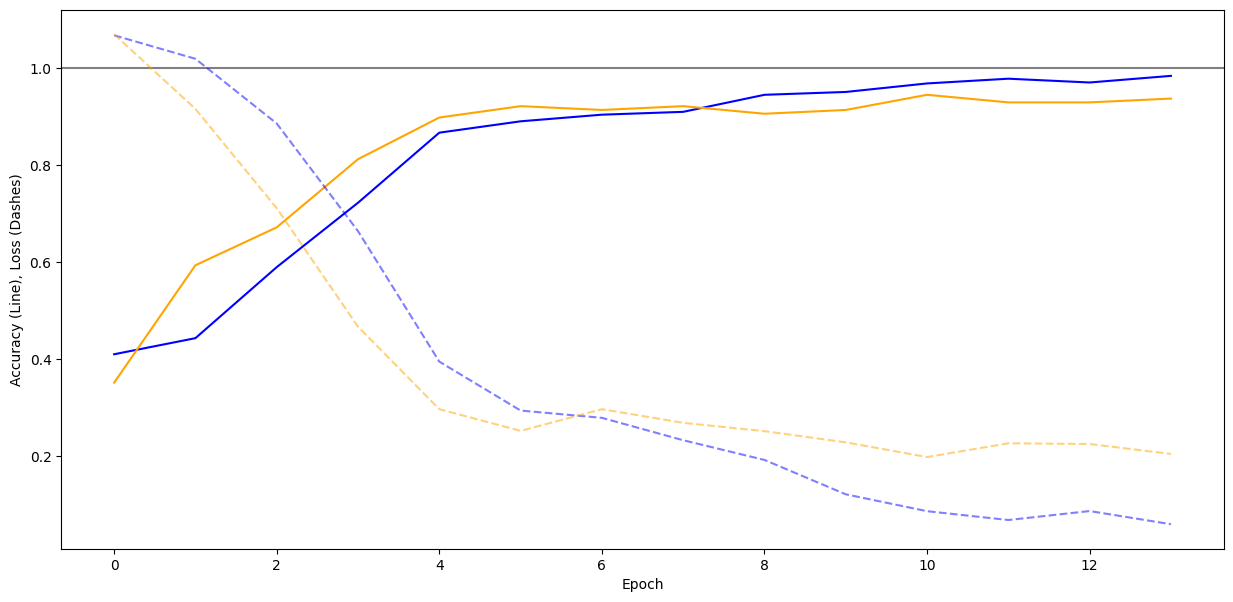

In [13]:
show_training_results(history, model)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [ ]:
model.save('gesture_recognition')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

2/2 [==============================] - 0s 10ms/step
before [[1.50550127e-01 8.48544240e-01 9.05683672e-04]
 [9.78303254e-01 2.16964986e-02 2.77908725e-07]
 [9.99996424e-01 3.46671663e-06 7.04923480e-08]
 [4.64115525e-03 9.95358527e-01 3.99742589e-07]
 [9.99967456e-01 3.19178362e-05 6.55595727e-07]
 [9.99884725e-01 1.15076582e-04 2.75234555e-07]
 [5.92810509e-04 9.99406219e-01 9.49669243e-07]
 [9.99979019e-01 2.08035108e-05 7.83531604e-08]
 [9.99675155e-01 3.24677152e-04 2.43280169e-07]
 [9.99876499e-01 1.22867554e-04 6.38594827e-07]
 [1.72429616e-04 9.99820888e-01 6.69124347e-06]
 [9.41375434e-01 5.85998222e-02 2.46508662e-05]
 [9.98584509e-01 1.41381484e-03 1.61221988e-06]
 [9.99984980e-01 1.49886400e-05 2.90710345e-09]
 [9.99034643e-01 9.65206185e-04 1.11575666e-07]
 [9.03995988e-06 9.99990940e-01 6.84010804e-09]
 [9.98103142e-01 1.89613341e-03 6.84843542e-07]
 [9.99984145e-01 1.58009952e-05 1.77574022e-09]
 [9.90993083e-01 9.00639873e-03 4.96100029e-07]
 [9.73572254e-01 2.64156442e-

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

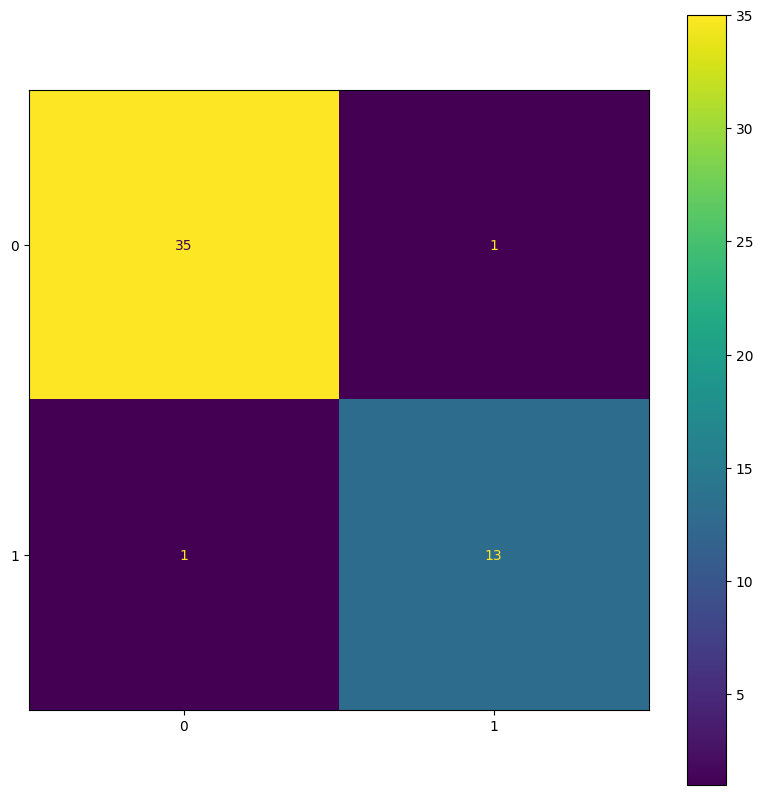

In [35]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass